# K-Means Clustering: A Hands‑On, Visual Guide

**What you’ll learn**
- Intuition behind K-means and when to use it
- How scaling affects distance-based clustering
- Picking the right `k` using the Elbow and Silhouette methods
- Fitting and visualizing K-means on synthetic and real data
- Evaluating clustering quality and common pitfalls

> Run the cells in order. Each plotting cell renders **one chart** using `matplotlib`.


In [ ]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8,5)
print('Libraries ready. Numpy', np.__version__, '| Pandas', pd.__version__)

Libraries ready. Numpy 2.0.2 | Pandas 2.2.2


## Part A — Build Intuition with a Synthetic Dataset
We’ll create a two-dimensional dataset with `make_blobs` so we can **see** how K-means groups points.

In [ ]:
# Create 2D synthetic data
X, y_true = make_blobs(n_samples=800, centers=4, cluster_std=1.25, random_state=42)
df = pd.DataFrame(X, columns=['x1','x2'])
df.head()

,x1,x2
0,-9.323549,7.536543
1,-6.192062,-8.090540
2,3.651786,2.562505
3,3.759449,0.212593
4,5.339617,3.324146


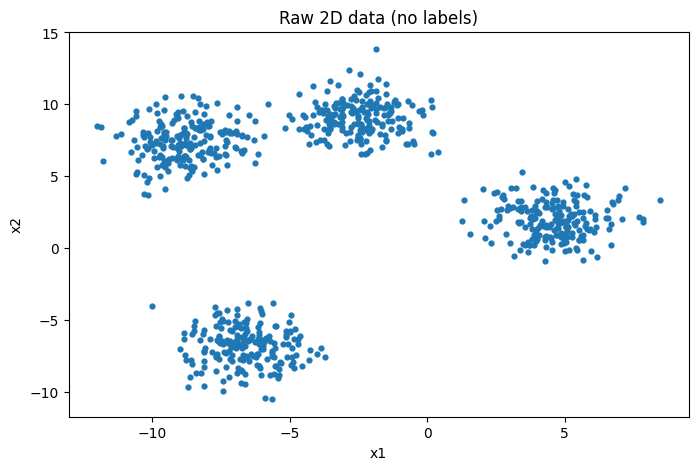

In [ ]:
# Visualize raw data (unlabeled for now)
plt.figure()
plt.scatter(df['x1'], df['x2'], s=12)
plt.title('Raw 2D data (no labels)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Why scaling matters
K-means uses **Euclidean distance**. Features on larger scales dominate the distance. We’ll scale the data so each feature has zero mean and unit variance.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pd.DataFrame(X_scaled, columns=['x1_scaled','x2_scaled']).head()

,x1_scaled,x2_scaled
0,-1.139104,0.733367
1,-0.542053,-1.740276
2,1.334780,-0.053983
3,1.355307,-0.425956
4,1.656583,0.066578


## Choosing `k`: Elbow Method
The **inertia** (a.k.a. WCSS) measures how tightly points cluster around centroids. We fit models for different `k` and look for an "elbow" where additional clusters yield diminishing returns.

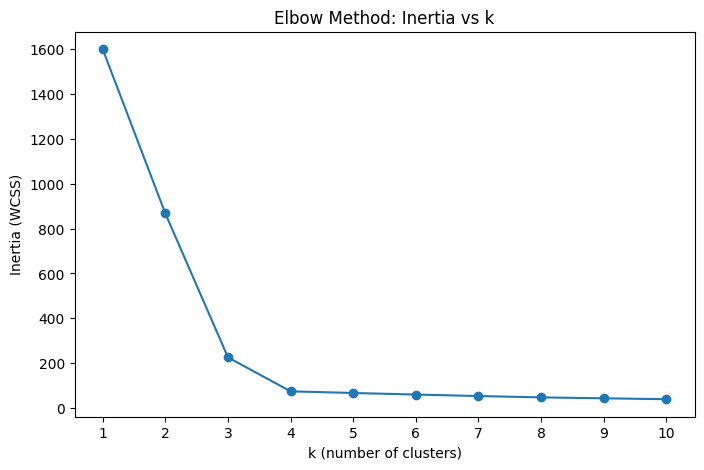

[(1, np.float64(1600.0)),
 (2, np.float64(867.27)),
 (3, np.float64(225.47)),
 (4, np.float64(73.98)),
 (5, np.float64(66.63)),
 (6, np.float64(59.62)),
 (7, np.float64(53.03)),
 (8, np.float64(46.92)),
 (9, np.float64(42.9)),
 (10, np.float64(38.79))]

In [ ]:
inertias = []
k_values = list(range(1, 11))
for k in k_values:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method: Inertia vs k')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_values)
plt.show()

list(zip(k_values, np.round(inertias, 2)))

## Choosing `k`: Silhouette Analysis
The **silhouette score** ranges from -1 to 1; higher is better. It balances cohesion (within cluster) and separation (between clusters).

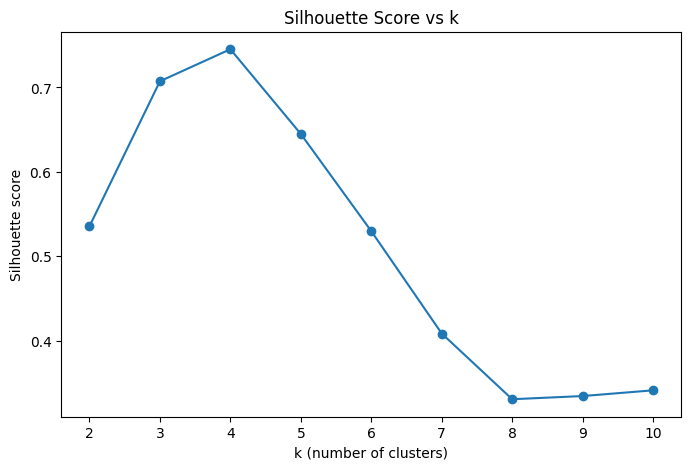

[(2, np.float64(0.535)),
 (3, np.float64(0.707)),
 (4, np.float64(0.745)),
 (5, np.float64(0.645)),
 (6, np.float64(0.53)),
 (7, np.float64(0.409)),
 (8, np.float64(0.331)),
 (9, np.float64(0.334)),
 (10, np.float64(0.341))]

In [ ]:
sil_scores = []
k_values2 = list(range(2, 11))
for k in k_values2:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure()
plt.plot(k_values2, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette score')
plt.xticks(k_values2)
plt.show()

list(zip(k_values2, np.round(sil_scores, 3)))

## Fit the final model
Pick a `k` suggested by the analyses above (for this dataset, `k=4` is often a good choice).

In [ ]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_
print('Cluster sizes:', dict(pd.Series(labels).value_counts().sort_index()))
print('Inertia (WCSS):', round(kmeans.inertia_, 2))
print('Silhouette:', round(silhouette_score(X_scaled, labels), 3))

Cluster sizes: {0: np.int64(200), 1: np.int64(199), 2: np.int64(201), 3: np.int64(200)}
Inertia (WCSS): 73.98
Silhouette: 0.745


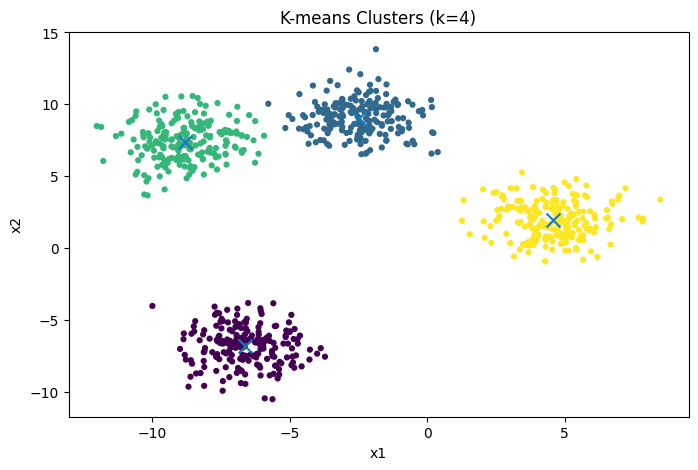

In [ ]:
# Visualize clustered data in original 2D space
plt.figure()
plt.scatter(df['x1'], df['x2'], c=labels, s=12)
centroids_unscaled = scaler.inverse_transform(centroids)
plt.scatter(centroids_unscaled[:,0], centroids_unscaled[:,1], marker='x', s=100)
plt.title(f'K-means Clusters (k={best_k})')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### (Bonus) See centroid movement across iterations
Scikit-learn doesn’t expose per-iteration centroids directly, so below is a **minimal K-means** implementation to visualize how centroids move during training. This is for education—not performance.

In [ ]:
def kmeans_track(X, k, max_iter=20, random_state=42):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(len(X), size=k, replace=False)
    centroids = X[idx].astype(float)
    history = [centroids.copy()]
    for _ in range(max_iter):
        # Assign
        dists = ((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = dists.argmin(axis=1)
        # Update
        new_centroids = np.vstack([
            X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)
        ])
        history.append(new_centroids.copy())
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return labels, np.array(history)

labels2, history = kmeans_track(X_scaled, k=best_k, max_iter=15, random_state=7)
print('Iterations recorded:', history.shape[0]-1)

Iterations recorded: 8


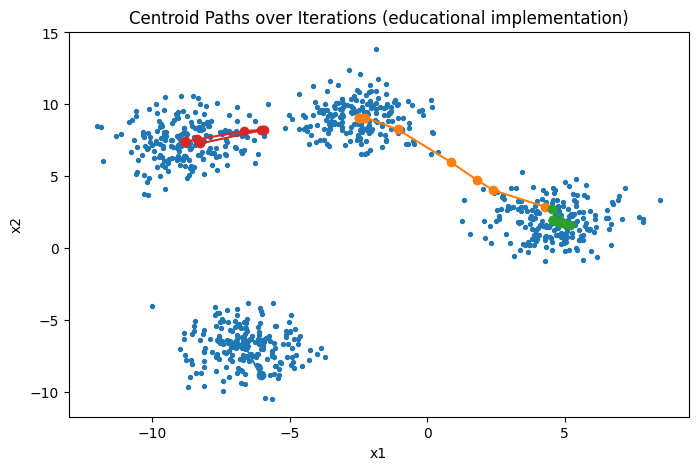

In [ ]:
# Plot centroid trajectories in the original space
centroid_paths = [history[:, i, :] for i in range(best_k)]
centroid_paths_unscaled = [scaler.inverse_transform(p) for p in centroid_paths]

plt.figure()
plt.scatter(df['x1'], df['x2'], s=8)
for path in centroid_paths_unscaled:
    plt.plot(path[:,0], path[:,1], marker='o')
plt.title('Centroid Paths over Iterations (educational implementation)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Part B — Real Data: Iris Dataset
We’ll cluster the classic Iris dataset (4 features). Because it’s 4D, we’ll use **PCA** to project to 2D for visualization.

> This is **unsupervised** learning. We won’t use species labels while fitting, but we’ll compare post hoc for insight.

In [ ]:
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_species = iris.target
scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)
pca = PCA(n_components=2, random_state=42)
X_iris_pca = pca.fit_transform(X_iris_scaled)
X_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Pick `k` for Iris
We’ll check Elbow and Silhouette again; historically, Iris often works well with `k=3`.

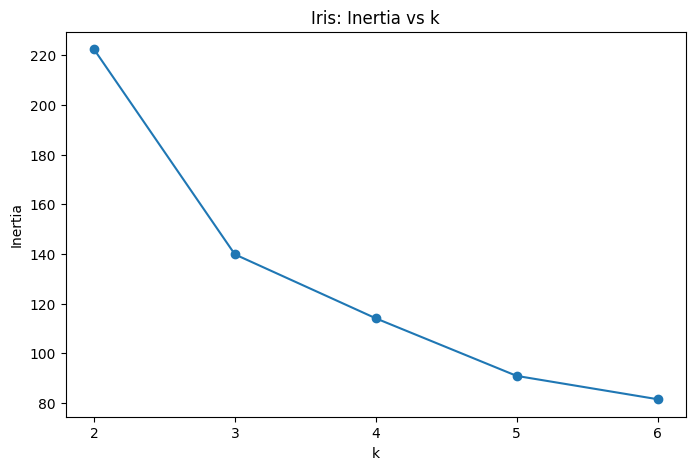

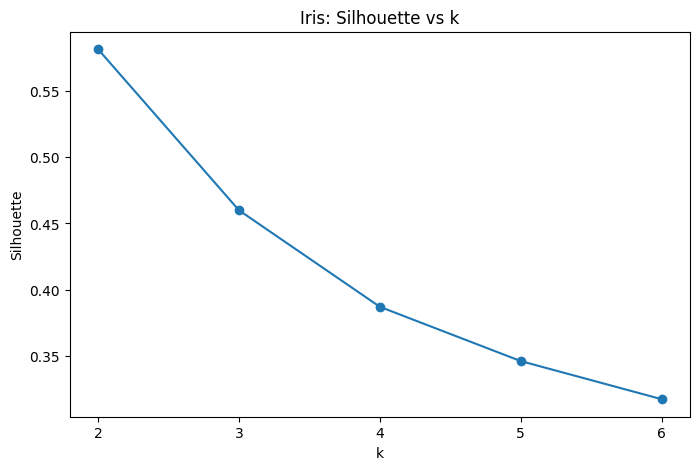

[(2, np.float64(222.36), np.float64(0.582)),
 (3, np.float64(139.82), np.float64(0.46)),
 (4, np.float64(114.09), np.float64(0.387)),
 (5, np.float64(90.93), np.float64(0.346)),
 (6, np.float64(81.54), np.float64(0.317))]

In [ ]:
inertias_i = []
sils_i = []
kvals = list(range(2,7))
for k in kvals:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels_i = km.fit_predict(X_iris_scaled)
    inertias_i.append(km.inertia_)
    sils_i.append(silhouette_score(X_iris_scaled, labels_i))

plt.figure()
plt.plot(kvals, inertias_i, marker='o')
plt.title('Iris: Inertia vs k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(kvals)
plt.show()

plt.figure()
plt.plot(kvals, sils_i, marker='o')
plt.title('Iris: Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.xticks(kvals)
plt.show()

list(zip(kvals, np.round(inertias_i,2), np.round(sils_i,3)))

### Fit and visualize Iris with `k=3`

In [ ]:
k_iris = 3
km_iris = KMeans(n_clusters=k_iris, init='k-means++', n_init=10, random_state=42)
pred_iris = km_iris.fit_predict(X_iris_scaled)
print('Silhouette (Iris):', round(silhouette_score(X_iris_scaled, pred_iris), 3))

Silhouette (Iris): 0.46


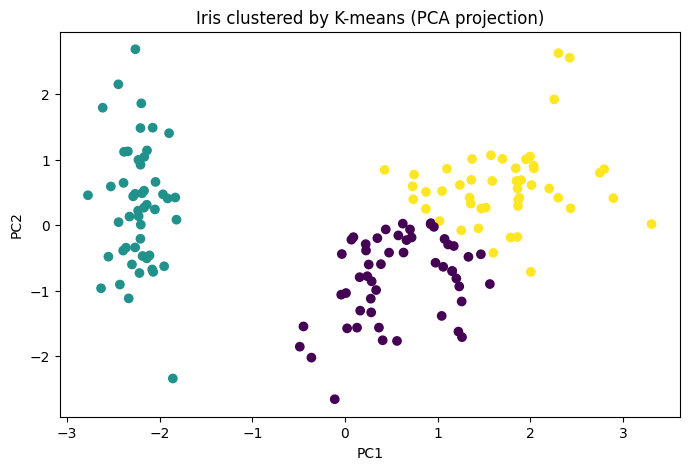

In [ ]:
# Visualize predicted clusters in PCA space
plt.figure()
plt.scatter(X_iris_pca[:,0], X_iris_pca[:,1], c=pred_iris)
plt.title('Iris clustered by K-means (PCA projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

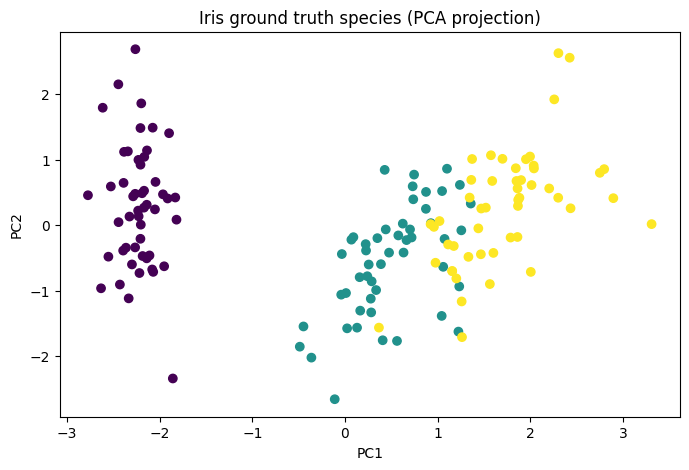

In [ ]:
# Visualize ground truth species in PCA space (for comparison only)
plt.figure()
plt.scatter(X_iris_pca[:,0], X_iris_pca[:,1], c=y_species)
plt.title('Iris ground truth species (PCA projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### External validation (optional, since clustering is unsupervised)
Comparing clusters to true species can be informative. We use two label-invariant scores:

In [ ]:
ari = adjusted_rand_score(y_species, pred_iris)
nmi = normalized_mutual_info_score(y_species, pred_iris)
print('Adjusted Rand Index:', round(ari, 3))
print('Normalized Mutual Information:', round(nmi, 3))

Adjusted Rand Index: 0.62
Normalized Mutual Information: 0.659
